# Henyey-Greenstein (HG) scattering phase function
The HG phase function depends on the **anisotropy factor** \( g \):


$$p(\cos\theta) = \frac{1 - g^2}{4\pi(1 + g^2 - 2g\cos\theta)^{3/2}}$$

where:

- $ \theta $ is the scattering angle between the incident and scattered directions.  
- $ g = \langle \cos\theta \rangle $ represents the **average cosine** of the scattering angle:
  - $ g = 0 $ → isotropic scattering  
  - $ g > 0 $ → forward scattering (typical for biological tissue)  
  - $ g < 0 $ → backward scattering  

In a Monte Carlo simulation, we don’t directly sample $ \theta $ from this distribution; instead, we use an **inverse transform method** to generate $ \cos\theta $ values that follow this probability law.

#### Sampling $ \cos\theta $

Using a uniform random number $\xi \in [0, 1)$, the cosine of the scattering angle is sampled as:

$$
\cos\theta =
\begin{cases}
2\xi - 1, & \text{if } g = 0 \text{ (isotropic)} \\
\dfrac{1 + g^2 - \left(\frac{1 - g^2}{1 - g + 2g\xi}\right)^2}{2g}, & \text{if } g \neq 0
\end{cases}
$$

This expression ensures that the resulting directions are statistically consistent with the HG phase function.

In [ ]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [2]:
def get_cos_theta(g):
    """Sampling the Henyey-Greenstein scattering phase function."""
    if g == 0:
        return 2 * random.random() - 1
    mu = (1 - g**2) / (1 - g + 2 * g * random.random())
    return (1 + g**2 - mu**2) / (2.0 * g)

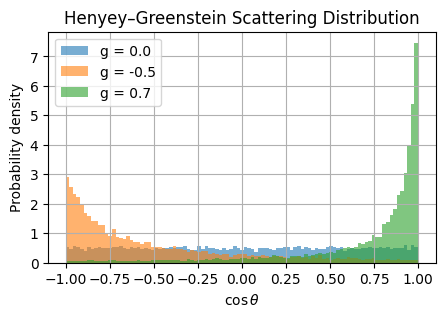

In [12]:
# Visualise sampled cos(theta) distribution for different g
N = 10000
gs = [0.0, -0.5, 0.7]
bins = np.linspace(-1, 1, 100)

plt.figure(figsize=(5,3))

for g in gs:
    samples = [get_cos_theta(g) for _ in range(N)]
    plt.hist(samples, bins=bins, density=True, alpha=0.6, label=f"g = {g}")

plt.xlabel(r"$\cos\theta$")
plt.ylabel("Probability density")
plt.title("Henyey–Greenstein Scattering Distribution")
plt.legend()
plt.grid(True)
plt.show()

### Photon Direction Update

After a scattering event, the photon’s direction changes. The `spin()` function updates the photon’s direction cosines $(\mu_x, \mu_y, \mu_z)$ based on a new random scattering angle.

This is done by sampling two random angles:
- The **polar angle** $ \theta $, obtained from the Henyey–Greenstein function.
- The **azimuthal angle** $ \phi $, uniformly distributed in $[0, 2\pi)$.

### Rotating the Photon Direction

We represent a photon’s direction by a unit vector:

$$
\vec{\mu} = (\mu_x, \mu_y, \mu_z)
$$

After scattering:
- $ \theta $ defines how much the photon deviates from its current direction.
- $ \phi $ defines the rotation around the photon’s local axis.

The new direction is computed using spherical coordinate rotation.

If the current direction is not parallel to the z-axis, the new direction components are:

$$
\begin{aligned}
\mu'_x &= \frac{\sin\theta}{\sqrt{1 - \mu_z^2}}(\mu_x \mu_z \cos\phi - \mu_y \sin\phi) + \mu_x \cos\theta \\
\mu'_y &= \frac{\sin\theta}{\sqrt{1 - \mu_z^2}}(\mu_y \mu_z \cos\phi + \mu_x \sin\phi) + \mu_y \cos\theta \\
\mu'_z &= -\sqrt{1 - \mu_z^2}\sin\theta \cos\phi + \mu_z \cos\theta
\end{aligned}
$$

If the photon is already along the z-axis ($\mu_z = ±1$), we avoid division by zero by using a simpler expression.

In [14]:
def spin(mu_x, mu_y, mu_z, g):
    """Compute the new photon direction after scattering."""
    costheta = get_cos_theta(g)
    phi = 2 * math.pi * random.random()
    sintheta = math.sqrt(1.0 - costheta**2)
    sinphi = math.sin(phi)
    cosphi = math.cos(phi)

    # Handle special cases when photon moves along z-axis
    if mu_z == 1.0:
        mu_x = sintheta * cosphi
        mu_y = sintheta * sinphi
        mu_z = costheta
    elif mu_z == -1.0:
        mu_x = sintheta * cosphi
        mu_y = -sintheta * sinphi
        mu_z = -costheta
    else:
        denom = math.sqrt(1.0 - mu_z**2)
        ux = sintheta * (mu_x * mu_z * cosphi - mu_y * sinphi) / denom + mu_x * costheta
        uy = sintheta * (mu_y * mu_z * cosphi + mu_x * sinphi) / denom + mu_y * costheta
        uz = -denom * sintheta * cosphi + mu_z * costheta
        mu_x, mu_y, mu_z = ux, uy, uz

    # Normalize (optional for numerical stability)
    norm = math.sqrt(mu_x**2 + mu_y**2 + mu_z**2)
    mu_x /= norm
    mu_y /= norm
    mu_z /= norm

    return mu_x, mu_y, mu_z

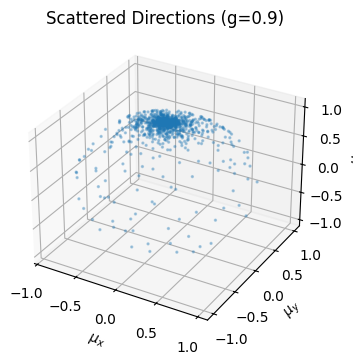

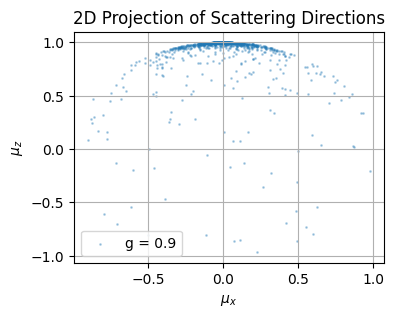

In [68]:
from mpl_toolkits.mplot3d import Axes3D

def sample_directions(g, N=1000):
    """Generate scattered directions."""
    directions = []
    for _ in range(N):
        mu_x, mu_y, mu_z = 0, 0, 1
        mu_x, mu_y, mu_z = spin(mu_x, mu_y, mu_z, g)
        directions.append((mu_x, mu_y, mu_z))
    return np.array(directions)

# Sample directions visualisation
g = 0.9
dirs = sample_directions(g)
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dirs[:,0], dirs[:,1], dirs[:,2], s=2, alpha=0.3)
ax.set_title(f"Scattered Directions (g={g})")
ax.set_xlabel(r"$\mu_x$"); ax.set_ylabel(r"$\mu_y$"); ax.set_zlabel(r"$\mu_z$")
plt.show()

# 2D Projection of Scattering directions
plt.figure(figsize=(4, 3))
plt.scatter(dirs[:,0], dirs[:,2], s=1, alpha=0.3, label=f"g = {g}")
plt.xlabel(r"$\mu_x$"); plt.ylabel(r"$\mu_z$")
plt.title("2D Projection of Scattering Directions")
plt.legend(); plt.grid(True)
plt.show()

### Monte Carlo Simulation: Photon Transmission Through a Scattering Slab

Simulate how photons travel through a thin slab that both absorbs and scatters light.

This is done by tracing many photons through random scattering and absorption events, using the Monte Carlo method.

Each photon starts at the slab surface and moves until it either:
- **Exits forward** (transmission),
- **Exits backward** (reflection), or
- **Loses its weight** due to **absorption** inside the material.

When light propagates in a scattering medium (like biological tissue, paint, or polymer):

- **Absorption coefficient** $ \sigma_a $: probability per unit length that a photon is absorbed.
- **Scattering coefficient** $ \sigma_s $: probability per unit length that a photon scatters.
- **Total attenuation** $ \sigma_t = \sigma_a + \sigma_s $
- **Mean free path** (average step length) $ \ell = 1/\sigma_t $

At each step:
1. Sample a random step length:
   $$
   s = -\frac{\ln(\xi)}{\sigma_t}
   $$
   where $ \xi $ is a uniform random number.

2. Move the photon by distance $ s $ along its current direction.

3. Decide whether it is **absorbed** or **scattered**:
   - Fraction absorbed: $ \sigma_a / \sigma_t $
   - Fraction scattered: $ \sigma_s / \sigma_t $

4. If scattered, update direction with the `spin()` function.

5. If the photon crosses the slab boundary, record whether it is **transmitted** or **reflected**.


In [74]:
def mc_simulation_records_transmission(
    records,
    size,
    thickness,
    sigma_a=1.5,
    sigma_s=1.5,
    g=0.0,
    nphotons=100000,
    m=10,
    slabsize=0.5,
):
    """
    Monte Carlo simulation of photon transport in a scattering + absorbing slab.

    Parameters
    ----------
    records : np.ndarray
        2D array to store transmitted photon weights (intensity map).
    size : int
        Size of the record grid.
    thickness : float
        Slab thickness (distance photons must travel through).
    sigma_a : float, optional
        Absorption coefficient (default = 1.5).
    sigma_s : float, optional
        Scattering coefficient (default = 1.5).
    g : float, optional
        Anisotropy factor for Henyey–Greenstein scattering (-1 ≤ g ≤ 1).
    nphotons : int, optional
        Number of photons to simulate (default = 100000).
    m : int, optional
        Russian roulette survival multiplier (default = 10).
    slabsize : float, optional
        Width of the illuminated area (default = 0.5).

    Returns
    -------
    records : np.ndarray
        Updated intensity map of transmitted photons.
    A, T, R : float
        Average absorbed, transmitted, and reflected fractions per photon.
    """
    sigma_t = sigma_a + sigma_s
    d = thickness
    T = R = A = 0.0

    for _ in range(nphotons):
        w = 1.0                     # photon weight
        x = y = z = 0.0             # initial position
        mu_x, mu_y, mu_z = 0, 0, 1  # initial direction (downward)

        while w > 0:
            # Step length sampled from exponential distribution
            s = -math.log(random.random()) / sigma_t
            dist_to_boundary = (d - z) / mu_z if mu_z > 0 else -z / mu_z

            # If photon crosses the slab boundary
            if s > dist_to_boundary:
                xi = int(((x + slabsize / 2) / slabsize) * size)
                yi = int(((y + slabsize / 2) / slabsize) * size)

                if mu_z > 0 and 0 <= xi < size and 0 <= yi < size:
                    records[yi, xi] += w
                    T += w
                elif mu_z < 0 and 0 <= xi < size and 0 <= yi < size:
                    R += w
                break

            # Move photon
            x += s * mu_x
            y += s * mu_y
            z += s * mu_z

            # Absorption (reduce photon weight)
            absorbed = w * (sigma_a / sigma_t)
            w -= absorbed
            A += absorbed

            # Russian roulette for small weights
            if w < 0.001:
                if random.random() > 1.0 / m:
                    break
                w *= m

            # Scatter (update direction)
            mu_x, mu_y, mu_z = spin(mu_x, mu_y, mu_z, g)

    return records, A / nphotons, T / nphotons, R / nphotons

A = 0.471, T = 0.513, R = 0.007, Sum = 0.991


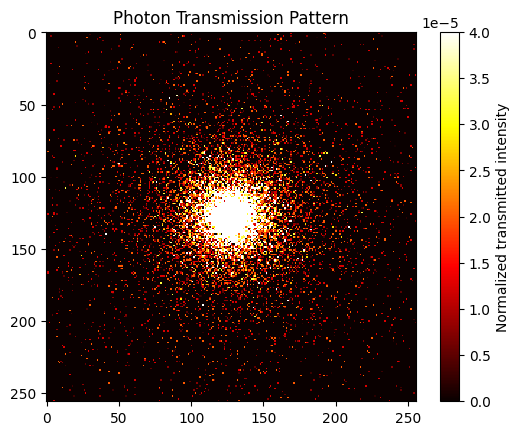

In [80]:
size = 256
records = np.zeros((size, size), dtype=np.float64)

records, A, T, R = mc_simulation_records_transmission(
    records,
    size=size,
    thickness=0.5,
    sigma_a=1.2,
    sigma_s=2.0,
    g=0.9,
    nphotons=50000,
)
normalized = records / np.max(records)
plt.imshow(normalized, cmap='hot', interpolation='nearest',
           vmin=0, vmax=2*np.mean(normalized))
plt.colorbar(label='Normalized transmitted intensity')
plt.title('Photon Transmission Pattern')
plt.show()

### Visiualise trajectory of each photon

In [ ]:
def mc_simulation_records_path(
    num_photons,
    sigma_a=1.0,
    sigma_s=2.0,
    thickness=0.5,
    g=0.75,
    m=10,
    max_steps=None,
    record_start=True,
):
    """
    Simulate photon paths in a slab and return list of trajectories.
    Each trajectory is a list of (x,y,z) points including boundary exit.

    Parameters
    ----------
    num_photons : int
    sigma_a, sigma_s : float
    thickness : float
    g : float
    m : int
        Russian roulette multiplier.
    max_steps : int or None
        Safety cap on steps per photon (None = no cap).
    record_start : bool
        If True, include the starting point (0,0,0).

    Returns
    -------
    trajectories : list[list[tuple(float,float,float)]]
    """
    EPS = 1e-12

    sigma_t = sigma_a + sigma_s
    d = thickness
    scatter_frac = sigma_s / sigma_t

    trajectories = [[] for _ in range(num_photons)]

    for pid in range(num_photons):
        w = 1.0
        x = y = z = 0.0
        mu_x = mu_y = 0.0
        mu_z = 1.0

        if record_start:
            trajectories[pid].append((x, y, z))

        steps = 0
        while w > 0.0:
            if max_steps is not None and steps >= max_steps:
                break
            steps += 1

            # Sample free path
            s = -math.log(max(EPS, random.random())) / sigma_t

            # Distance to boundary along current direction
            if abs(mu_z) < EPS:
                dist_to_boundary = float('inf')  # won't hit boundary this step
            elif mu_z > 0:
                dist_to_boundary = (d - z) / mu_z if z < d else 0.0
            else:
                dist_to_boundary = -z / mu_z if z > 0 else 0.0

            # Exits this step?
            if s > dist_to_boundary:
                if dist_to_boundary != float('inf'):
                    x += dist_to_boundary * mu_x
                    y += dist_to_boundary * mu_y
                    z += dist_to_boundary * mu_z
                    trajectories[pid].append((x, y, z))  # record exit point
                break

            # Move to collision site
            x += s * mu_x
            y += s * mu_y
            z += s * mu_z
            trajectories[pid].append((x, y, z))

            # Absorption (weight-reduction scheme)
            w *= scatter_frac

            # Russian roulette for tiny weights
            if w < 1e-3:
                if random.random() > 1.0 / m:
                    break
                w *= m

            # Scatter
            mu_x, mu_y, mu_z = spin(mu_x, mu_y, mu_z, g)

    return trajectories

In [ ]:
def plot_trajectories_2d(trajectories, max_traj=20):
    plt.figure(figsize=(6, 5))
    for traj in trajectories[:max_traj]:
        if len(traj) >= 2:
            xs, ys, zs = zip(*traj)
            plt.plot(xs, zs, linewidth=1, alpha=0.7)
    plt.xlabel('X'); plt.ylabel('Z')
    plt.title('Photon Trajectories (X–Z projection)')
    plt.grid(True)
    plt.show()

def plot_trajectories_3d(trajectories, max_traj=10):
    from mpl_toolkits.mplot3d import Axes3D  
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    for traj in trajectories[:max_traj]:
        if len(traj) >= 2:
            xs, ys, zs = zip(*traj)
            ax.plot(xs, ys, zs, linewidth=1, alpha=0.8)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    plt.show()

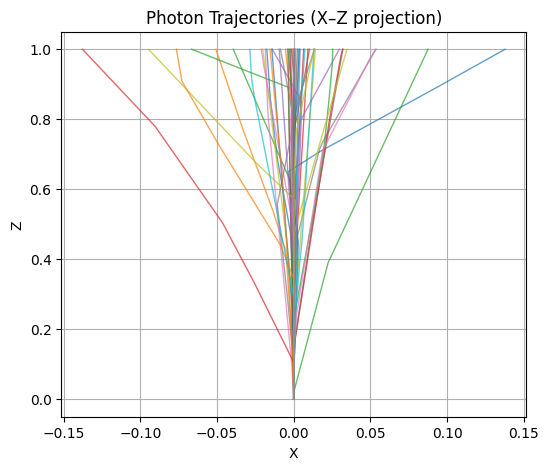

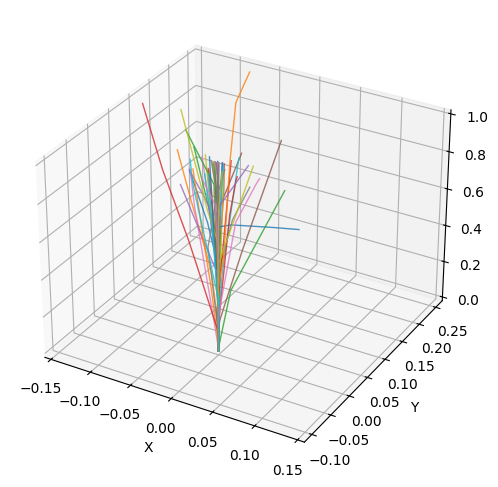

In [106]:
trajectories = mc_simulation_records_path(
    num_photons=100,
    sigma_a=1.0,
    sigma_s=2.0,
    thickness=1,
    g=0.99,
    m=10,
    max_steps=10000,
)

plot_trajectories_2d(trajectories, max_traj=50) 
plot_trajectories_3d(trajectories, max_traj=50)